In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [ ]:
PATH = 'unichannel_exp/config_1_adam/'

In [3]:
# Load the results
accuracy_scores = np.load(PATH + 'accuracy_scores.npy')
precision_scores = np.load(PATH + 'precision_scores.npy')
recall_scores = np.load(PATH + 'recall_scores.npy')
f1_scores = np.load(PATH + 'f1_scores.npy')

# Losses
e_train_losses = np.load(PATH + 'e_train_losses.npy')
e_test_losses = np.load(PATH + 'e_test_losses.npy')
b_train_losses = np.load(PATH + 'b_train_losses.npy')
b_test_losses = np.load(PATH + 'b_test_losses.npy')

# get the shape of all
print(f"Accuracy scores shape: {accuracy_scores.shape}")
print(f"Precision scores shape: {precision_scores.shape}")
print(f"Recall scores shape: {recall_scores.shape}")
print(f"F1 scores shape: {f1_scores.shape}")
print(f"E train losses shape: {e_train_losses.shape}")
print(f"E test losses shape: {e_test_losses.shape}")
print(f"B train losses shape: {b_train_losses.shape}")

Accuracy scores shape: (0,)
Precision scores shape: (0,)
Recall scores shape: (0,)
F1 scores shape: (0,)
E train losses shape: (75,)
E test losses shape: (75,)
B train losses shape: (358425,)


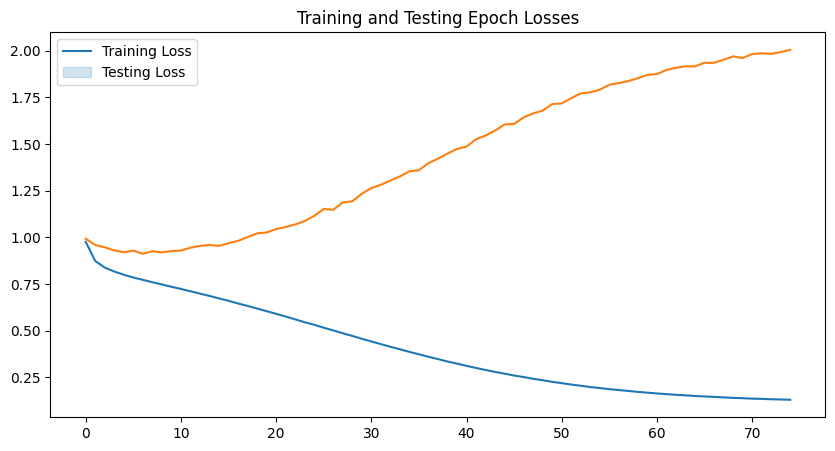

In [4]:
# Plot the Losses
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(len(e_train_losses)), y=e_train_losses, ax=ax)
sns.lineplot(x=range(len(e_test_losses)), y=e_test_losses, ax=ax)
plt.title('Training and Testing Epoch Losses')
plt.legend(['Training Loss', 'Testing Loss'])
plt.show()


In [5]:
# Import the Model .pth file for evaluation metrics
from capture24.patch_tst import PatchTST
import yaml

# load the config file
with open('capture24/configs/config_1.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['num_batches'] = 128
model = PatchTST(config)
model.load_state_dict(torch.load(f'{PATH}/patchtst_model.pth', weights_only=True, map_location=torch.device('mps')))
model.eval()
print(model)
print(f"Model loaded")


PatchTST(
  (inst_norm): InstanceNorm1d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (patching_layer): PatchingLayer()
  (flatten1): Flatten(start_dim=0, end_dim=1)
  (linear1): Linear(in_features=16, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (flatten2): Flatten(start_dim=1, end_

In [6]:
import gzip
from capture24.patch_tst import C24_Dataset
from torch.utils.data import DataLoader
import json
# Run Single Evaluation  on the Test Set
with gzip.open('capture24/final_data_1024/X_test.npy.gz', 'rb') as f:
    X_test = np.load(f)

with gzip.open('capture24/final_data_1024/Y_test.npy.gz', 'rb') as f:
    Y_test = np.load(f)

# Load the index to label and label to index
with open('capture24/final_data_1024/label_to_index.json', 'r') as f:
    data = json.load(f)

idx_to_label = data['index_to_label']
label_to_idx = data['label_to_index']

# INsert into loader
test_dataset = C24_Dataset(X_test, Y_test, idx_to_label, label_to_idx)
test_loader = DataLoader(
    test_dataset, 
    batch_size=128, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False, 
    drop_last=True, 
    persistent_workers=False, 
    prefetch_factor=None,
)

In [7]:
from torchmetrics.classification import MulticlassF1Score, ConfusionMatrix, CohenKappa, MulticlassMatthewsCorrCoef
from torch.utils.data import Subset
import tqdm
f1_score = MulticlassF1Score(num_classes=10, average='macro')
f1_score_micro = MulticlassF1Score(num_classes=10, average='micro')
f1_score_none = MulticlassF1Score(num_classes=10, average=None)
cm = ConfusionMatrix(num_classes=10, task='multiclass')
ck = CohenKappa(task = 'multiclass', num_classes=10)
mcc = MulticlassMatthewsCorrCoef(num_classes=10)


# Need to utilize bootstrapping to get the confidence intervals - n = 100 per the paper Capture24
# select total length N of test set

N = len(Y_test)

for x, y in test_loader:
    outputs = model(x)

    preds = outputs.argmax(dim=1)


    f1_score.update(preds, y)
    f1_score_micro.update(preds, y)
    f1_score_none.update(preds, y)
    cm.update(preds, y)
    ck.update(preds, y)
    mcc.update(preds, y)
    

# Evaluation Metrics - append to the lists
print(f"F1 score {f1_score.compute()}")
print(f"f1_score micro: {f1_score_micro.compute()}")
print(f"F1-score None: {f1_score_none.compute()}")
print(f"CK Score: {ck.compute()}")
print(f"MCC Score: {mcc.compute()}")

# Reset the metrics
f1_score.reset()
f1_score_micro.reset()
f1_score_none.reset()
ck.reset()
mcc.reset()

# Confusion Matrix
cm.compute()


F1 score 0.38426926732063293
f1_score micro: 0.6504354476928711
F1-score None: tensor([0.6212, 0.3391, 0.0363, 0.1882, 0.7009, 0.8874, 0.1387, 0.0838, 0.5325,
        0.3146])
CK Score: 0.523451030254364
MCC Score: 0.5239911079406738


tensor([[ 1538,   118,    46,    55,   218,     4,    15,    43,   348,   115],
        [   47,  8119,   518,  1330,  6825,   338,   170,  1270,   605,  4733],
        [  101,  1496,   126,   263,  1081,    82,    51,   245,   578,  1052],
        [  102,  2298,   203,  2509,  4077,   302,   102,   818,   601,  5707],
        [  107,  4853,   334,  1768, 72609, 12041,   116,  3515,  1207,  4008],
        [    1,   250,    19,   123,  9632, 97016,     5,   308,    88,   313],
        [  118,   369,    70,   253,   546,    50,   244,   146,   104,   644],
        [   24,  1237,    76,   481,  4782,   498,    35,   757,   295,  1259],
        [  314,   782,   135,   354,  2304,   204,    81,   400,  5502,   695],
        [  100,  4414,   347,  2810,  4567,   357,   155,  1113,   564,  7564]])

In [8]:
# Plot the evaluation distributions
evals = [f1_scores_boot, f1_scores_micro_boot, f1_scores_none_boot, ck_boot, mcc_boot]
evals_names = ['F1 Score', 'F1 Score Micro', 'F1 Score None', 'Cohen Kappa', 'MCC']
for i, eval in enumerate(evals):
    plt.figure(figsize=(10, 5))
    sns.histplot(
        eval,
        stat='density',
        kde=True,
        bins=20,
        ax=ax
    )
    ax.set_title(evals_names[i])
    ax.set_xlabel(evals_names[i])
    ax.set_ylabel('Density')
    plt.show()

NameError: name 'f1_scores_boot' is not defined

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

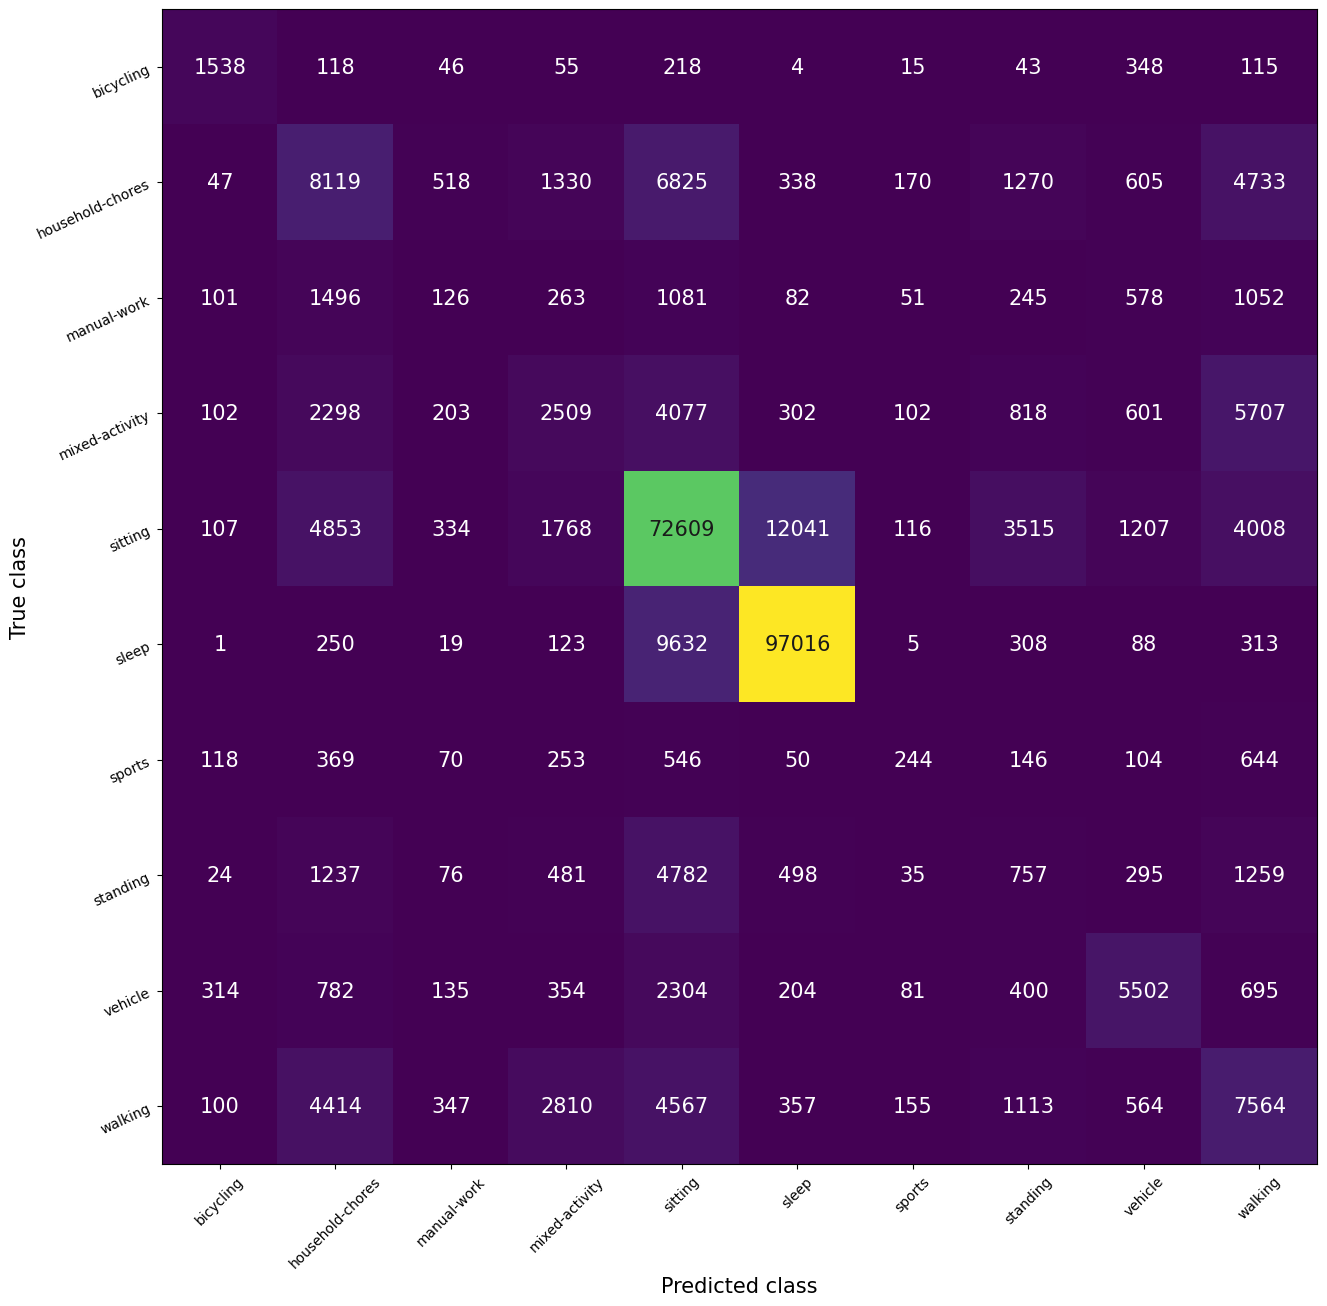

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
cm.plot(ax=ax, labels=idx_to_label.values())
